In [11]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 6.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

## Load the Data

In [2]:
df = pd.read_csv('2020_NHLDraft_ScoutingReport.csv')

In [3]:
df.head()

,Player,Report
0,Alexis Lafreniere,You've doubtless heard Alexis Lafreniere's nam...
1,Quentin Byfield,Being a scout is equal parts accounting for wh...
2,Lucas Raymond,The first tier of players in this year's draft...
3,Marco Rossi,It's not the size of the dog in the fight but ...
4,Jamie Drysdale,Erie Otters defenceman Jamie Drysdale could've...


## Preprocess the Data

In [4]:
def preprocess_all(text):
    
    # Remove Punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    tokens = text.split()
    
    ENGstopwords = stopwords.words('english')
    text = [word for word in tokens if word not in ENGstopwords]
    
    porter = PorterStemmer()
    stemmed_text = [porter.stem(word) for word in text]
    
    wnl = WordNetLemmatizer()
    lemma_text = [wnl.lemmatize(word) for word in stemmed_text]
    
    return lemma_text

In [5]:
df['Report_clean'] = df['Report'].apply(lambda x: preprocess_all(x))

In [ ]:
df.head()

,Player,Report,Report_clean
0,Alexis Lafreniere,You've doubtless heard Alexis Lafreniere's nam...,"[youv, doubtless, heard, alexi, lafrenier, nam..."
1,Quentin Byfield,Being a scout is equal parts accounting for wh...,"[be, scout, equal, part, account, what, alread..."
2,Lucas Raymond,The first tier of players in this year's draft...,"[the, first, tier, player, year, draft, three,..."
3,Marco Rossi,It's not the size of the dog in the fight but ...,"[it, size, dog, fight, size, fight, dog, ottaw..."
4,Jamie Drysdale,Erie Otters defenceman Jamie Drysdale could've...,"[eri, otter, defenceman, jami, drysdal, couldv..."


In [8]:
def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

# Create a list of review by applying text_preprocessing function
df['Report_clean_list'] = list(map(preprocess_all, df.Report))

# Return to string with to_string function
df['Report_clean'] = list(map(to_string, df['Report_clean_list']))

In [9]:
df.head()

,Player,Report,Report_clean,Report_clean_list
0,Alexis Lafreniere,You've doubtless heard Alexis Lafreniere's nam...,youv doubtless heard alexi lafrenier name roll...,"[youv, doubtless, heard, alexi, lafrenier, nam..."
1,Quentin Byfield,Being a scout is equal parts accounting for wh...,be scout equal part account what alreadi proje...,"[be, scout, equal, part, account, what, alread..."
2,Lucas Raymond,The first tier of players in this year's draft...,the first tier player year draft three skater ...,"[the, first, tier, player, year, draft, three,..."
3,Marco Rossi,It's not the size of the dog in the fight but ...,it size dog fight size fight dog ottawa 67 cen...,"[it, size, dog, fight, size, fight, dog, ottaw..."
4,Jamie Drysdale,Erie Otters defenceman Jamie Drysdale could've...,eri otter defenceman jami drysdal couldv reaso...,"[eri, otter, defenceman, jami, drysdal, couldv..."


## EDA and Visualization

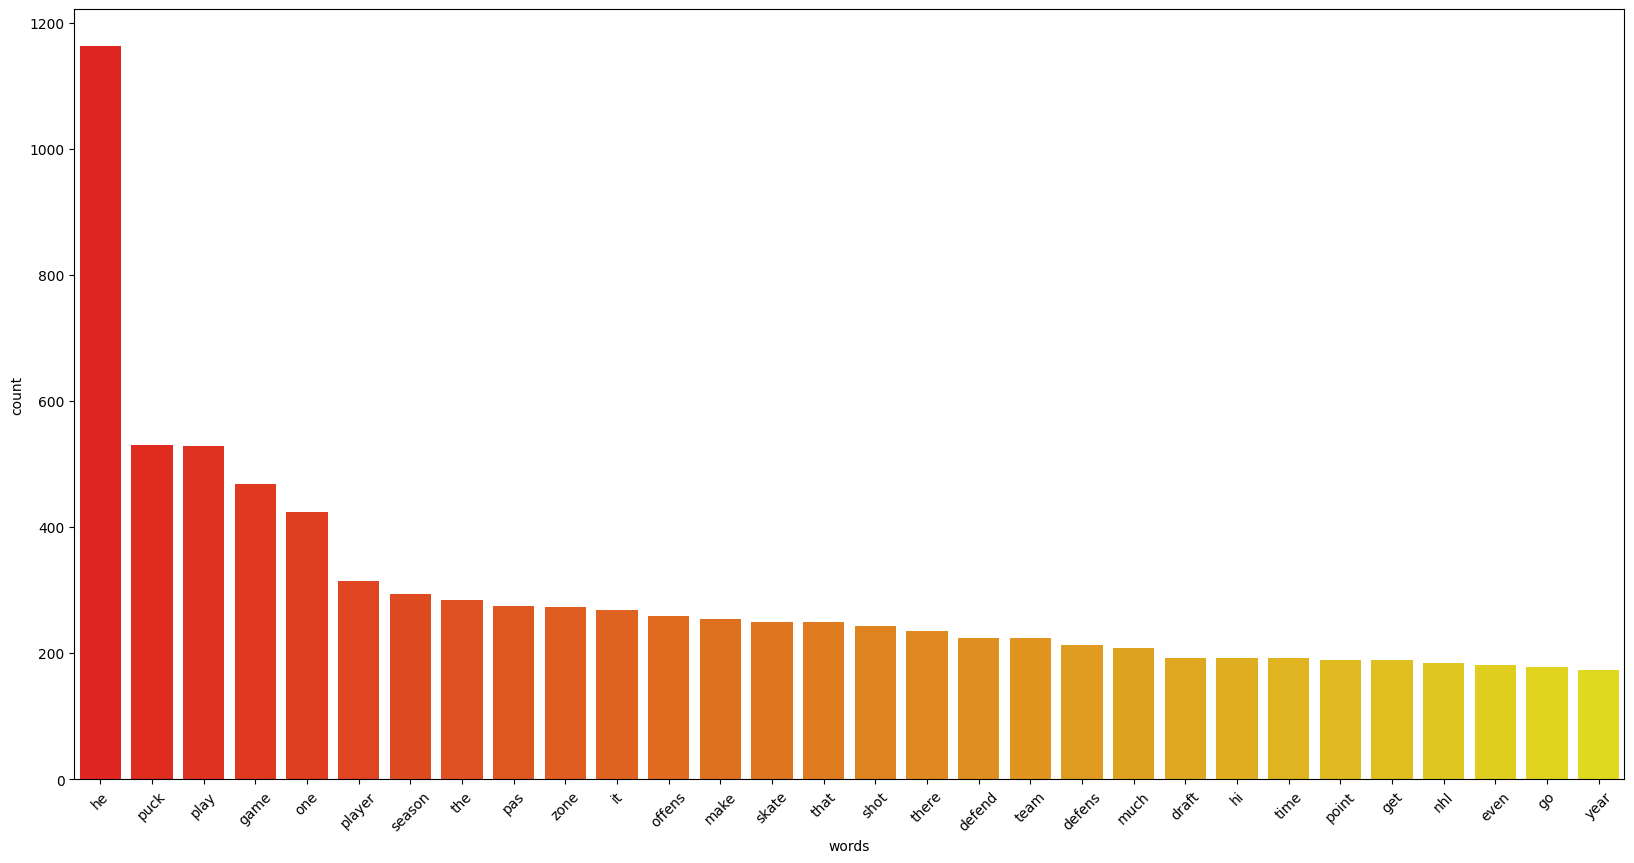

In [14]:
# Import Counter 
from collections import Counter

# Join all word corpus
review_words = ','.join(list(df['Report_clean'].values))

# Count and find the 30 most frequent
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'autumn')
plt.xticks(rotation=45);

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianlavecchia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


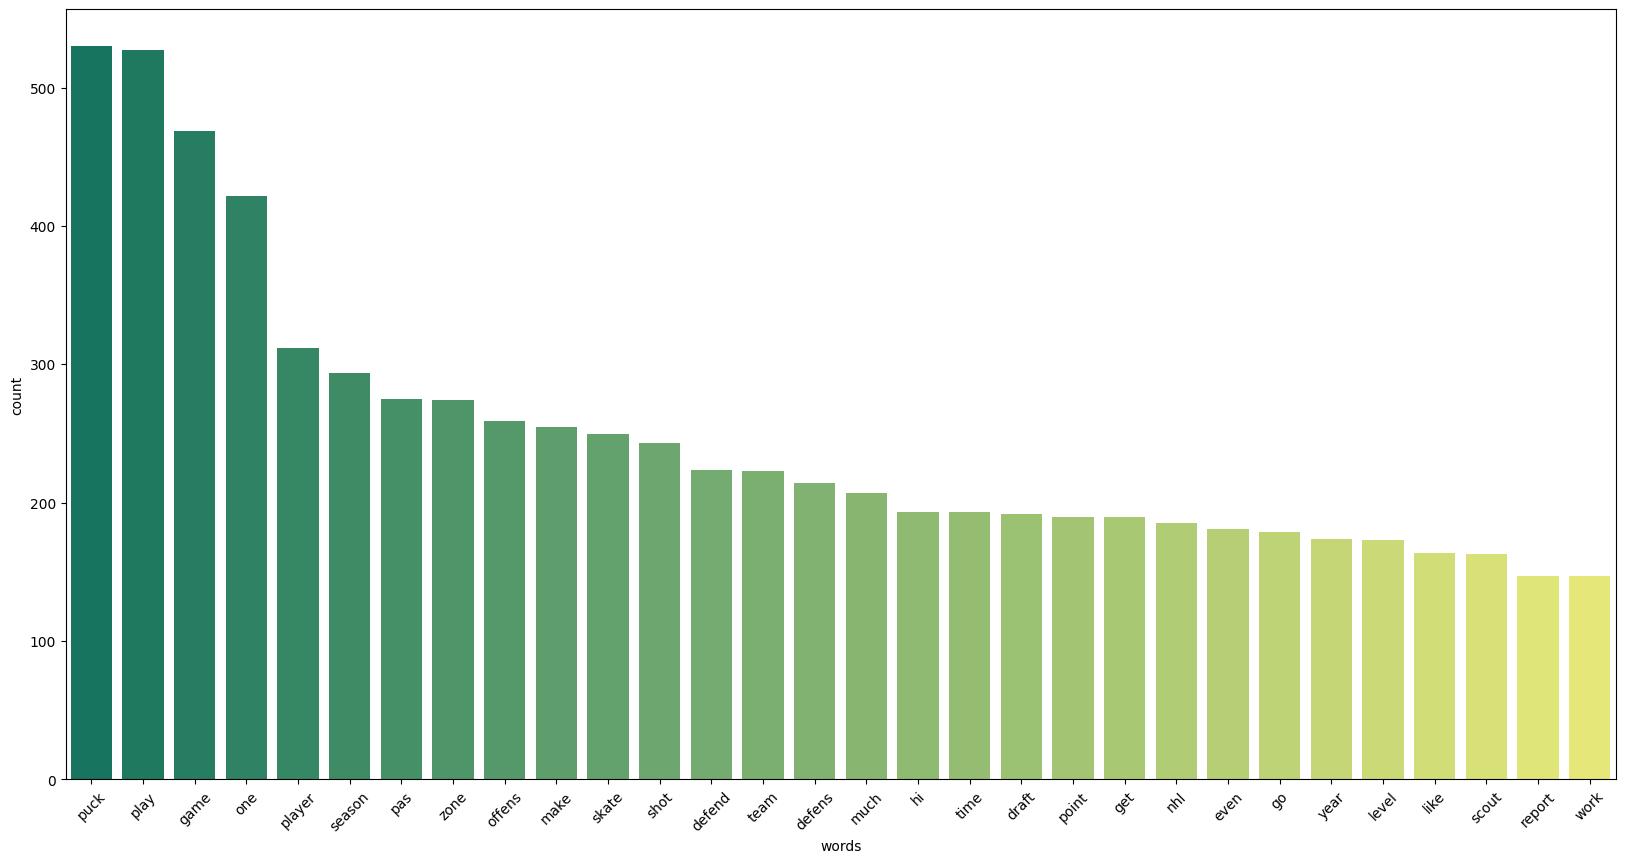

In [19]:
# Load the list of stopwords
nltk.download('stopwords')

stopwords_list = stopwords.words('english')
stopwords_list.extend(['he', 'the', 'it'])

df['Report_clean_list'] = [[word for word in line if word not in stopwords_list] for line in df['Report_clean_list']]
df['Report_clean'] = list(map(to_string, df['Report_clean_list']))

# Join all word corpus
review_words = ','.join(list(df['Report_clean'].values))

# Import Counter 
from collections import Counter

# Count and find the 30 most frequent
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'summer')
plt.xticks(rotation=45);

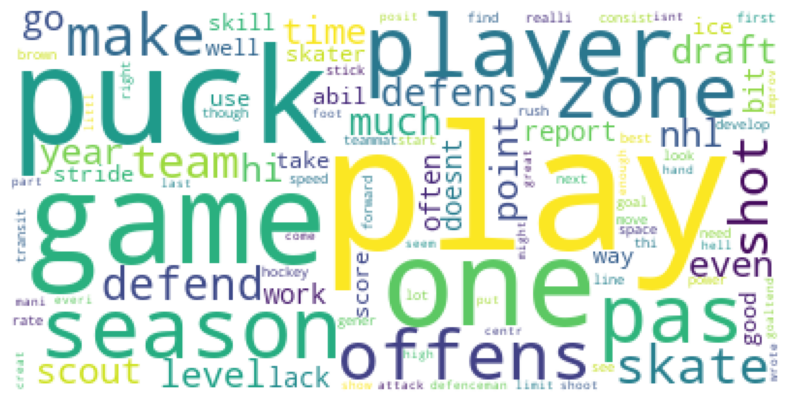

In [20]:
# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 100,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(review_words)
                      
# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Bag of Words

In [22]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [23]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(df['Report_clean_list'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['Report_clean_list']]

## Determining the Number of Topics

<AxesSubplot: xlabel='number_of_topics', ylabel='coherence_score'>

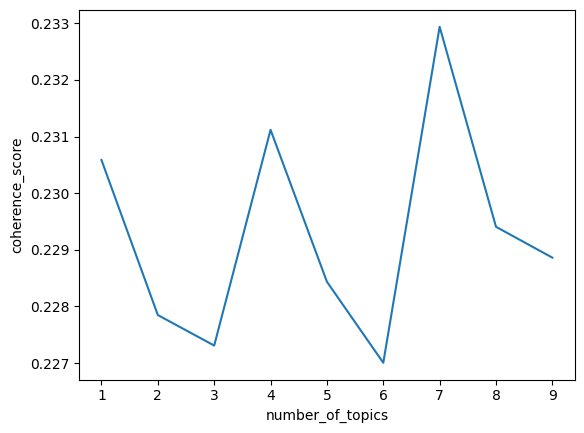

In [24]:
# Compute coherence score
number_of_topics = []
coherence_score = []

for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=df['Report_clean_list'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [25]:
topic_coherence

,number_of_topics,coherence_score
0,1,0.230586
1,2,0.227849
2,3,0.227310
3,4,0.231119
4,5,0.228436
5,6,0.227005
6,7,0.232938
7,8,0.229406
8,9,0.228862


## Creating a Base Model with LDA

In [26]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

In [27]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.016*"play" + 0.013*"game" + 0.012*"puck" + 0.008*"one" + 0.008*"make" + 0.008*"season" + 0.007*"skate" + 0.007*"pas" + 0.006*"player" + 0.006*"team"
Topic: 1 Word: 0.022*"cuyll" + 0.013*"mckown" + 0.011*"lengthi" + 0.010*"foudi" + 0.009*"robin" + 0.007*"sourdif" + 0.006*"vierl" + 0.006*"cardwel" + 0.005*"percentil" + 0.005*"jarventi"
Topic: 2 Word: 0.019*"defenceman" + 0.011*"gap" + 0.011*"greyhound" + 0.009*"carlil" + 0.009*"moor" + 0.009*"activ" + 0.009*"constantin" + 0.008*"ben" + 0.008*"rush" + 0.007*"school"
Topic: 3 Word: 0.045*"goaltend" + 0.015*"get" + 0.015*"movement" + 0.013*"come" + 0.012*"malik" + 0.011*"littl" + 0.011*"agil" + 0.011*"plenti" + 0.010*"america" + 0.010*"creas"
Topic: 4 Word: 0.014*"whl" + 0.012*"ljungman" + 0.010*"escap" + 0.009*"neighbour" + 0.009*"truscott" + 0.009*"finley" + 0.009*"persson" + 0.008*"cotton" + 0.008*"seeley" + 0.007*"bear"
Topic: 5 Word: 0.025*"mukhamadullin" + 0.016*"papp" + 0.012*"gordin" + 0.012*"certain" + 0.007*"gonca

In [30]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['Report_clean_list'],
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence score : ', coherence_lda)


Coherence score :  0.49085657899121277
